In [1]:
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from pprint import pprint
import tinydb as db
from tinydb.storages import MemoryStorage
#import pdb
import pygama.math.utils as pgu

import matplotlib
# matplotlib.use('Agg') # when running on cori
import matplotlib.pyplot as plt
plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

from pygama.flow import DataGroup
import pygama.lgdo as lh5
import pygama.math.histogram as pgh
import pygama.math.peak_fitting as pgf
#import psd_analysis as psd

#import calibration_jdetwiler as cb


dg = DataGroup('/global/homes/f/fnafis/krstc/krstc.json', load=True)

def plotting(plt, fontsize=20, xlabel='xlabel', ylabel='ylabel', title='title'):
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize*1.5)
    plt.ylabel(ylabel, fontsize=fontsize*1.5)
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize*2)
    
    
def draw_canvas(plt, fontsize=20, xlabel='xlabel', ylabel='count', title='title'):
    plt.figure(figsize=(20,16))
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize*1.5)
    plt.ylabel(ylabel, fontsize=fontsize*1.5)
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize*2)

#print all columns of dg
print(dg.fileDB.columns)
dg.fileDB

Index(['YYYY', 'cycle', 'daq_dir', 'daq_file', 'dd', 'dsp_id', 'mm', 'run',
       'runtype', 'skip', 'unique_key', 'raw_file', 'raw_path', 'dsp_file',
       'dsp_path', 'hit_file', 'hit_path', 'startTime', 'threshold', 'daq_gb',
       'stopTime', 'runtime'],
      dtype='object')


,YYYY,cycle,daq_dir,daq_file,dd,dsp_id,mm,run,runtype,skip,...,raw_path,dsp_file,dsp_path,hit_file,hit_path,startTime,threshold,daq_gb,stopTime,runtime
0,2020,2019,/2020/06/Data,2020-6-11-KrSTCRun2019,11,1.0,6,0.0,bkg,False,...,/raw,krstc_run0_cyc2019_dsp.lh5,/dsp,krstc_run0_cyc2019_hit.lh5,/hit,1.591914e+09,100.0,1.061043,1.591915e+09,13.714247
1,2020,2020,/2020/06/Data,2020-6-11-KrSTCRun2020,11,1.0,6,0.0,bkg,False,...,/raw,krstc_run0_cyc2020_dsp.lh5,/dsp,krstc_run0_cyc2020_hit.lh5,/hit,1.591915e+09,100.0,2.002383,1.591917e+09,25.816316
2,2020,2021,/2020/06/Data,2020-6-11-KrSTCRun2021,11,1.0,6,0.0,bkg,False,...,/raw,krstc_run0_cyc2021_dsp.lh5,/dsp,krstc_run0_cyc2021_hit.lh5,/hit,1.591917e+09,100.0,2.035477,1.591917e+09,12.557345
3,2020,2022,/2020/06/Data,2020-6-11-KrSTCRun2022,11,1.0,6,0.0,bkg,False,...,/raw,krstc_run0_cyc2022_dsp.lh5,/dsp,krstc_run0_cyc2022_hit.lh5,/hit,1.591917e+09,100.0,2.058530,1.591917e+09,1.206728
4,2020,2023,/2020/06/Data,2020-6-11-KrSTCRun2023,11,1.0,6,0.0,bkg,False,...,/raw,krstc_run0_cyc2023_dsp.lh5,/dsp,krstc_run0_cyc2023_hit.lh5,/hit,1.591917e+09,100.0,2.088009,1.591918e+09,1.213570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2022,2599,/2022/04/Data,2022-4-15-KrSTCRun2599,15,4.0,4,38.0,bkg,False,...,/raw,krstc_run38_cyc2599_dsp.lh5,/dsp,krstc_run38_cyc2599_hit.lh5,/hit,1.650048e+09,100.0,1.345234,1.650049e+09,19.170977
581,2022,2600,/2022/04/Data,2022-4-15-KrSTCRun2600,15,4.0,4,39.0,bkg,False,...,/raw,krstc_run39_cyc2600_dsp.lh5,/dsp,krstc_run39_cyc2600_hit.lh5,/hit,1.650049e+09,100.0,2.007099,1.650051e+09,28.685735
582,2022,2601,/2022/04/Data,2022-4-15-KrSTCRun2601,15,4.0,4,39.0,bkg,False,...,/raw,krstc_run39_cyc2601_dsp.lh5,/dsp,krstc_run39_cyc2601_hit.lh5,/hit,1.650051e+09,100.0,2.005029,1.650052e+09,28.607619
583,2022,2602,/2022/04/Data,2022-4-15-KrSTCRun2602,15,4.0,4,39.0,bkg,False,...,/raw,krstc_run39_cyc2602_dsp.lh5,/dsp,krstc_run39_cyc2602_hit.lh5,/hit,1.650052e+09,100.0,2.006409,1.650054e+09,28.940240


In [2]:
def show_raw_spectrum(dg):
    lh5_dir = dg.lh5_dir
    dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
    dsp_list = dsp_list[0]
    #pdb.set_trace
    edata = lh5.load_nda(dsp_list, ['trapEmax'], 'ORSIS3302DecoderForEnergy/dsp')
    rt_min = dg.fileDB['runtime'].sum()
    u_start = dg.fileDB.iloc[0]['startTime']
    t_start = pd.to_datetime(u_start, unit='s')
    print('Found energy data:', [(et, len(ev)) for et, ev in edata.items()])
    print(f'Runtime (min): {rt_min:.2f}')
    elo, ehi, epb, etype = 0, 8000, 10, 'trapEmax' #Histogram options

    ene_uncal = edata[etype] #energy_uncalibrated
    hist, bins, var = pgh.get_hist(ene_uncal, range=(elo, ehi), dx=epb)

    # normalize by runtime
    hist_rt = np.divide(hist, rt_min * 60)

    #plt.plot(np.nan, np.nan, '-w', lw=1, label=t_start)
    #pgh.plot_hist(hist, bins, var, linewidth=1.0)
    plt.semilogy(bins[1:], hist_rt, ds='steps', c='b', lw=1,
                 label=f'{etype}, {rt_min:.2f} mins')

    plt.xlabel(etype, ha='right', x=1)
    plt.ylabel('cts / sec', ha='right', y=1)
    plt.legend()
    plt.tight_layout()

#show_raw_spectrum(dg)


## Show waveforms

In [3]:
dg.fileDB.dsp_file

0       krstc_run0_cyc2019_dsp.lh5
1       krstc_run0_cyc2020_dsp.lh5
2       krstc_run0_cyc2021_dsp.lh5
3       krstc_run0_cyc2022_dsp.lh5
4       krstc_run0_cyc2023_dsp.lh5
                  ...             
580    krstc_run38_cyc2599_dsp.lh5
581    krstc_run39_cyc2600_dsp.lh5
582    krstc_run39_cyc2601_dsp.lh5
583    krstc_run39_cyc2602_dsp.lh5
584    krstc_run39_cyc2603_dsp.lh5
Name: dsp_file, Length: 585, dtype: object

In [4]:
calibration_consts = [0.431,0.132]

parameters = ['trapEmax', 'bl','AoE', 'dcr', 'ToE']


cycle_range = [2115, 2122]



lh5_dir = dg.lh5_dir #if:user, then:dg.lh5_user_dir; else:dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
hit_list = dsp_list[cycle_range[0]-2019:cycle_range[1]-2019]
#hit_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
print(hit_list)
df_hit = lh5.load_dfs(hit_list, parameters, 'ORSIS3302DecoderForEnergy/dsp')
df_hit['trapEmax_cal'] = np.polyval(calibration_consts, df_hit['trapEmax'])
df_hit


#kr
cycle_range_kr = [2147, 2202]



#dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
hit_list_kr = dsp_list[cycle_range_kr[0]-2019:cycle_range_kr[1]-2019]
#hit_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
print(hit_list_kr)
df_hit_kr = lh5.load_dfs(hit_list_kr, parameters , 'ORSIS3302DecoderForEnergy/dsp')
df_hit_kr['trapEmax_cal'] = np.polyval(calibration_consts, df_hit_kr['trapEmax'])
df_hit_kr


#pulser
cycle_range_puls = [2210, 2222]



#dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
hit_list_puls = dsp_list[cycle_range_puls[0]-2019:cycle_range_puls[1]-2019]
#hit_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
print(hit_list_puls)
df_hit_puls = lh5.load_dfs(hit_list_puls, parameters , 'ORSIS3302DecoderForEnergy/dsp')
df_hit_puls['trapEmax_cal'] = np.polyval(calibration_consts, df_hit_puls['trapEmax'])
df_hit_puls



#133Ba
cycle_range_ba = [2222, 2225]



#dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
hit_list_ba = dsp_list[cycle_range_ba[0]-2019:cycle_range_ba[1]-2019]
#hit_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
print(hit_list_ba)
df_hit_ba = lh5.load_dfs(hit_list_ba, parameters , 'ORSIS3302DecoderForEnergy/dsp')
df_hit_ba['trapEmax_cal'] = np.polyval(calibration_consts, df_hit_ba['trapEmax'])
df_hit_ba

96     /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
97     /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
98     /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
99     /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
100    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
101    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
102    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
dtype: object
128    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
129    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
130    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
131    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
132    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
133    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
134    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
135    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
136    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
137    /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krs...
138    /global/cf

,trapEmax,bl,AoE,dcr,ToE,trapEmax_cal
0,8423.164062,58097.910156,0.026217,0.561566,0.248499,3630.515625
1,38.062851,55992.882812,0.057914,0.567898,0.194705,16.537088
2,41.403759,56160.105469,0.048353,0.480110,0.191091,17.977020
3,38.755337,56339.648438,0.054441,0.791421,0.208856,16.835550
4,35.548134,56507.789062,0.062208,0.713489,0.229456,15.453245
...,...,...,...,...,...,...
367099,475.508209,58054.992188,0.037328,0.463594,0.350786,205.076035
367100,192.903061,58296.636719,0.094905,0.514501,0.826370,83.273224
367101,472.754852,58023.312500,0.067352,0.331672,0.621058,203.889343
367102,488.314056,58057.058594,0.062740,0.403354,0.584691,210.595352


In [5]:
b = {'a':[5,9],'aa':3}

In [6]:
# get total runtime from a cycle range
def get_runtime(dg, cycle_range):
    runtime = 0
    


def draw_runtime_normalized_hist(dg, runs=[['bkg',2141,2147]]):

    for run in runs:
        start_cycle = run[1]
        end_cycle = run[2]
        hist, bins, var = pgh.get_hist()

draw_runtime_normalized_hist(dg)

TypeError: get_hist() missing 1 required positional argument: 'data'

In [1]:
def show_wfs_by_cycle(dg, cycle_range=[2028,2038+1], cuts=[('trapEmax', 0, 8000),('bl',50000,600000)], ene_range=[0,13333], bl_range=[50000,600000], nwfs=20):
    """
    show waveforms in different energy regions.
    use the hit file to select events
    """
    # get file list and load hit data
    lh5_dir = dg.lh5_dir #if:user, then:dg.lh5_user_dir; else:dg.lh5_dir
    dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
    dsp_list = dsp_list[cycle_range[0]-2019:cycle_range[1]-2019]
    #hit_list = lh5_dir + dg.fileDB['hit_path'] + '/' + dg.fileDB['hit_file']
    hit_list = dsp_list #since regular hist list not available now
    print(hit_list)
    df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl','AoE', 'dcr'], 'ORSIS3302DecoderForEnergy/dsp')
    
    #df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'trapEmax_cal', 'bl','AoE', 'dcr_raw', 'tp_0', 'tp_50'], 'ORSIS3302DecoderForEnergy/hit')
    # print(df_hit)
    # print(df_hit.columns)

    # settings
    etype = 'trapEmax'
    #etype = 'trapEmax_cal'
    #nwfs = 20

    #creat new DCR
    const = 0.0555
    #df_hit['dcr_linoff'] = df_hit['dcr_raw'] + const*df_hit['trapEmax']
    df_hit['dcr_linoff'] = df_hit['dcr']
    #create 0-50
    #df_hit['tp0_50'] = df_hit['tp_50'] - df_hit['tp_0']
    df_hit['tp0_50'] = df_hit['tp_max']


    # elo, ehi, epb = 0, 100, 0.2 # low-e region
    # elo, ehi, epb = 0, 20, 0.2 # noise region
    elo, ehi, epb = ene_range[0], ene_range[1], 1 # 351 peak, cal
    # elo, ehi, epb = 1452, 1468, 1 # good physics events
#     elo, ehi, epb = 7100, 7200, 1 # good physics events, uncal
    # elo, ehi, epb = 6175, 6250, 1 # overflow peak
    # elo, ehi, epb = 5000, 5200, 0.2 # lower overflow peak
    
    #bl cut
    bl_low, bl_high = bl_range[0], bl_range[1]

    # # diagnostic plot
    # hE, xE, vE = pgh.get_hist(df_hit[etype], range=(elo, ehi), dx=epb)
    # plt.plot(xE[1:], hE, c='b', ds='steps')
    # plt.show()
    # exit()

    # select bulk waveforms
    idx = df_hit[etype].loc[(df_hit[etype] >= elo) &
                            (df_hit[etype] <= ehi) &
                            (df_hit['bl'] >= bl_low) &
                            (df_hit['bl'] <= bl_high)].index[:nwfs]
    raw_store = lh5.LH5Store()
    print(len(idx))
    tb_name = 'ORSIS3302DecoderForEnergy/raw'
    lh5_dir = dg.lh5_dir
    raw_list = lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']
    f_raw = raw_list.values[0] # fixme, only works for one file rn
    data_raw, nrows = raw_store.read_object(tb_name, f_raw, start_row=0, n_rows=idx[-1]+1)

    bulk_wfs_all = (data_raw['waveform']['values']).nda
    bulk_wfs = bulk_wfs_all[idx.values, :]
    del bulk_wfs_all
    ts = np.arange(0, bulk_wfs.shape[1]-1, 1)
    #ts = np.arange(0, bulk_wfs.shape[1], 1)
    
    #pdb.set_trace()
	
    
    # plot wfs
    draw_canvas(plt)
    for iwf in range(bulk_wfs.shape[0]):
        plt.plot(ts, bulk_wfs[iwf,:len(bulk_wfs[iwf])-1], lw=1, color = 'blue', label = 'Bulk')
        #plt.plot(ts, bulk_wfs[iwf], lw=1, color = 'blue', label = 'Bulk')
        

    plt.xlabel('time (clock ticks)', ha='right', x=1)
    plt.ylabel('ADC', ha='right', y=1)
    
    
    
   

#    #plot alpha wfs
#     for aiwf in range(alpha_wfs.shape[0]):
#         plt.plot(ats, alpha_wfs[aiwf,:len(alpha_wfs[aiwf])-1], lw=1, color = 'red', label = 'Alpha')

    #plt.title('Alpha versus bulk events')
    plt.title('right 351 Wfs run 82')
    plt.xlabel('time (clock ticks)', ha='right', x=1)
    plt.ylabel('ADC', ha='right', y=1)
    #plt.xlim(3500, 4500)
    #plt.ylim(9100, 10300)
    # plt.legend(loc='upper left')
    #plt.show()
    #plt.savefig('zoom_350_right_waveforms_run82.png', dpi=300)
    # plt.cla()

show_wfs_by_cycle(dg, cycle_range=[2028,2029], ene_range=[0,13333], 
                  bl_range=[0,570000])

NameError: name 'dg' is not defined

### data cleaning (baseline cut)

/tmp/ipykernel_61605/3588109311.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['aoe']= df_cut['A_10']/df_cut['trapEmax']
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


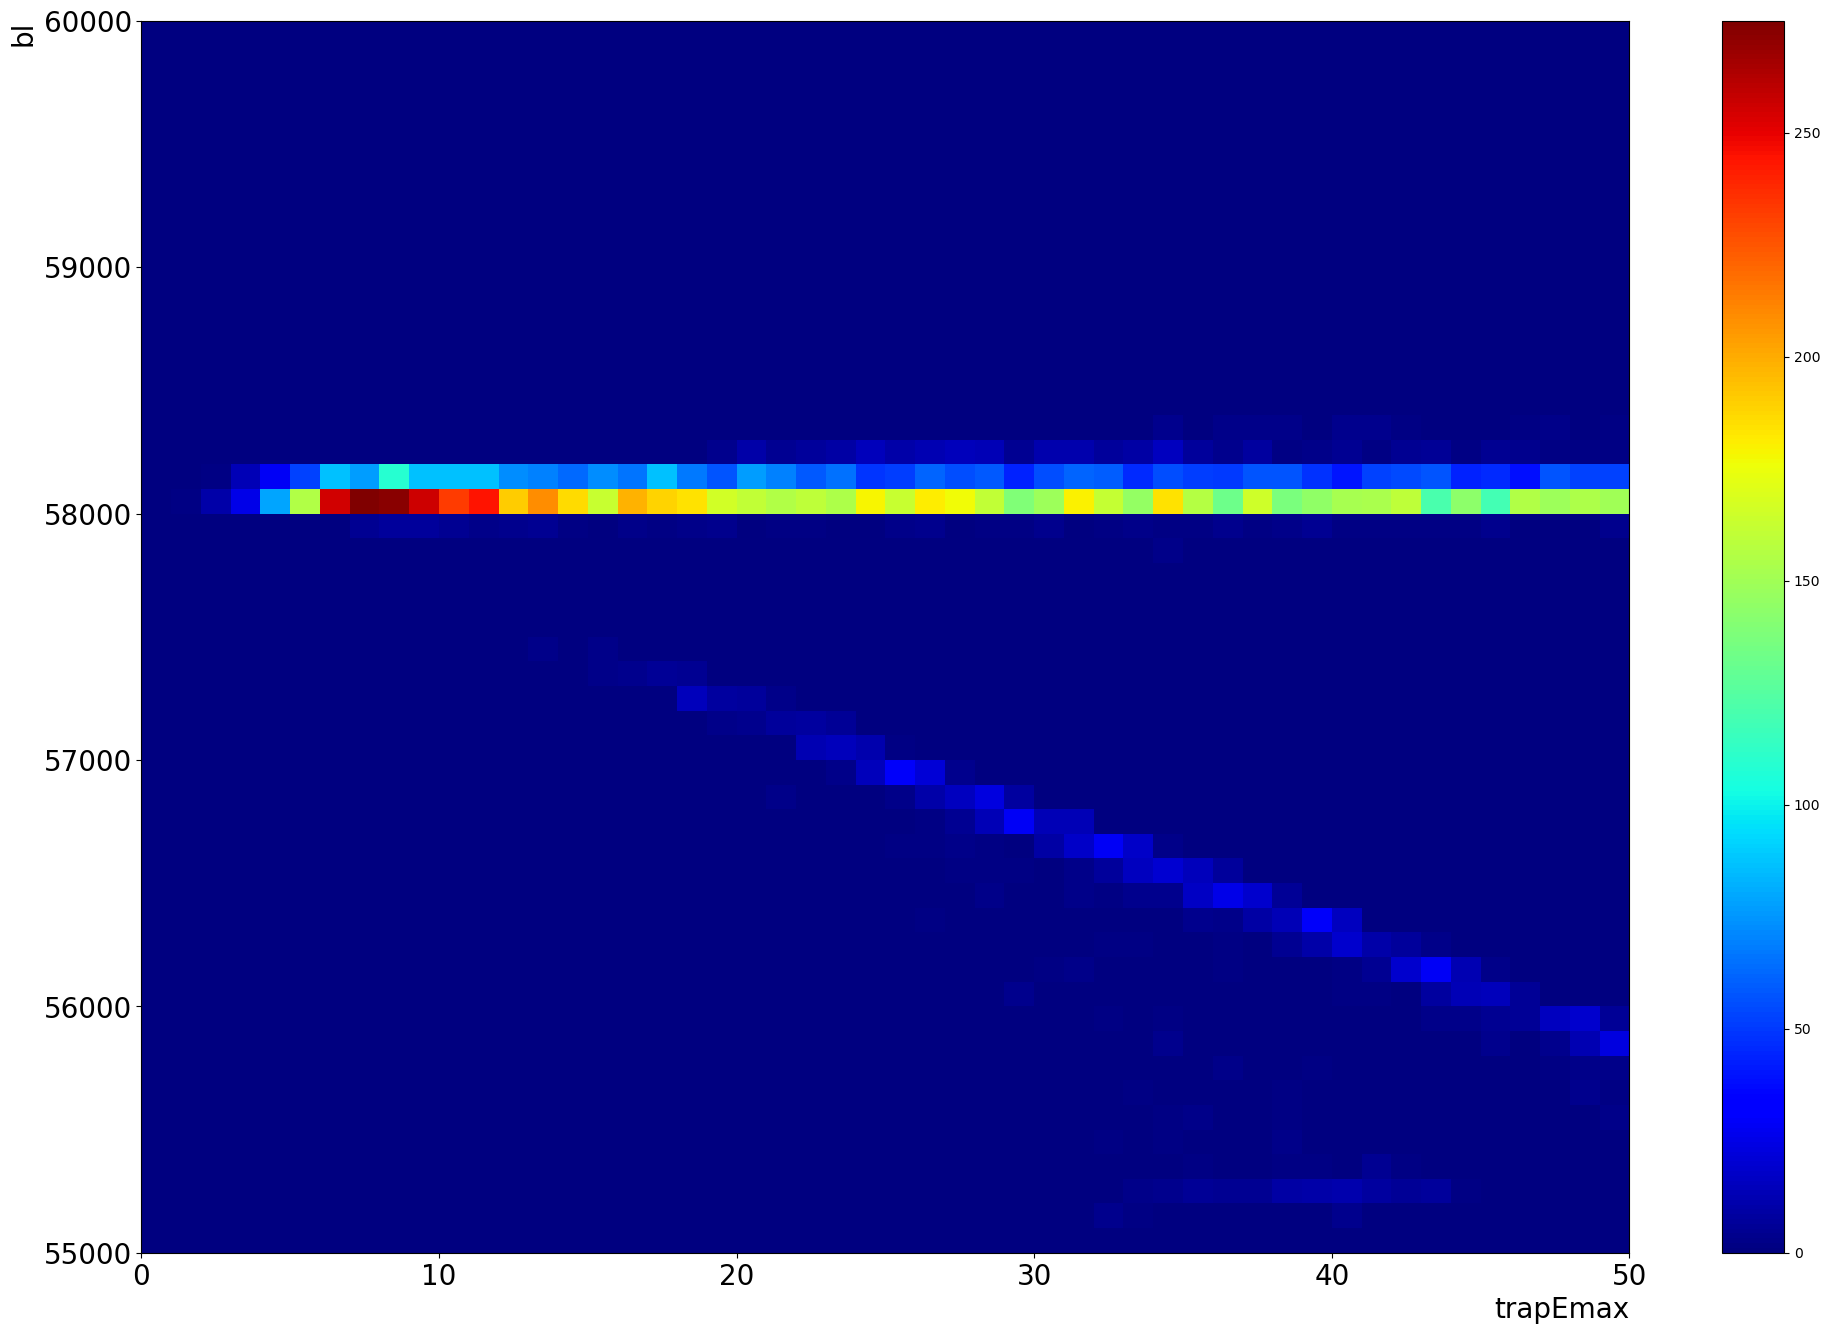

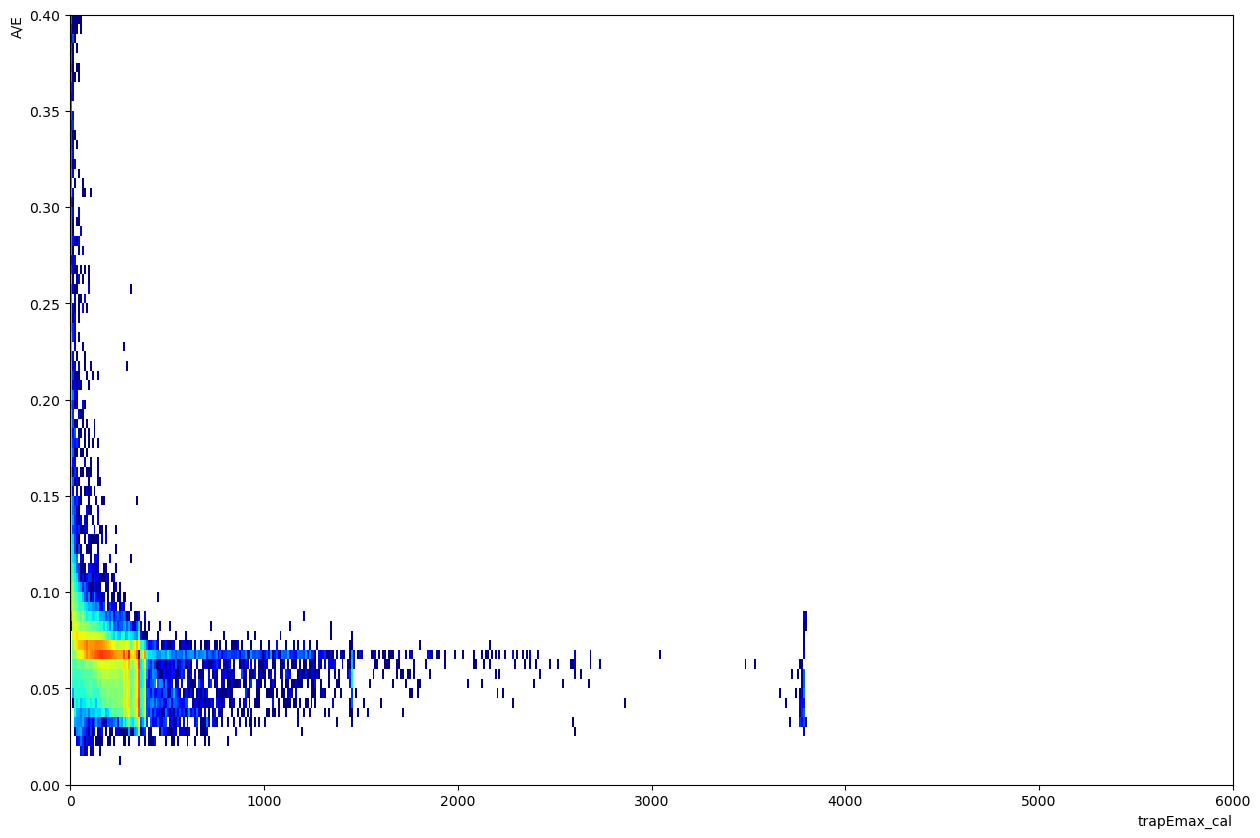

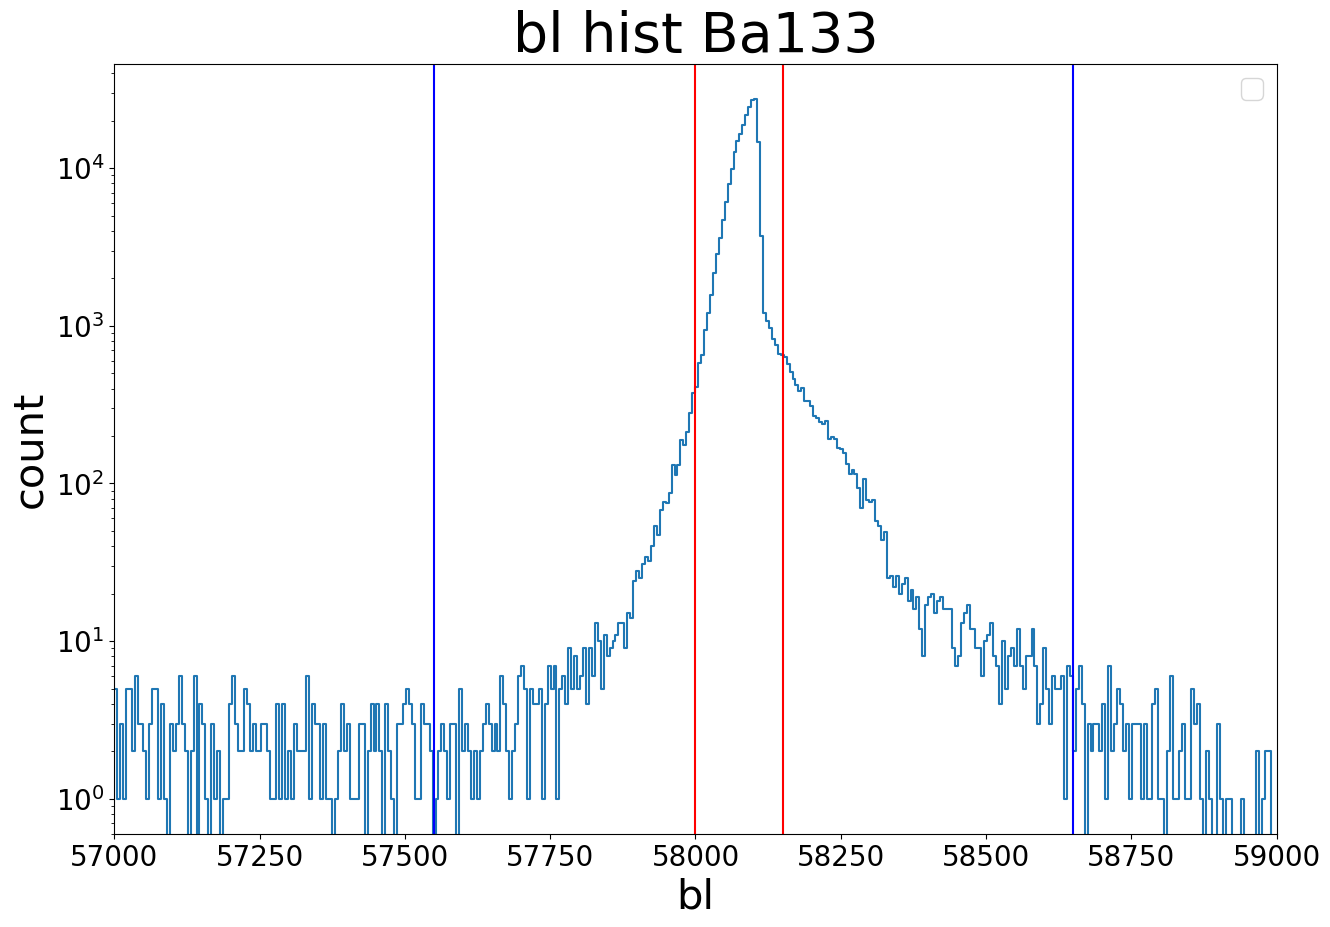

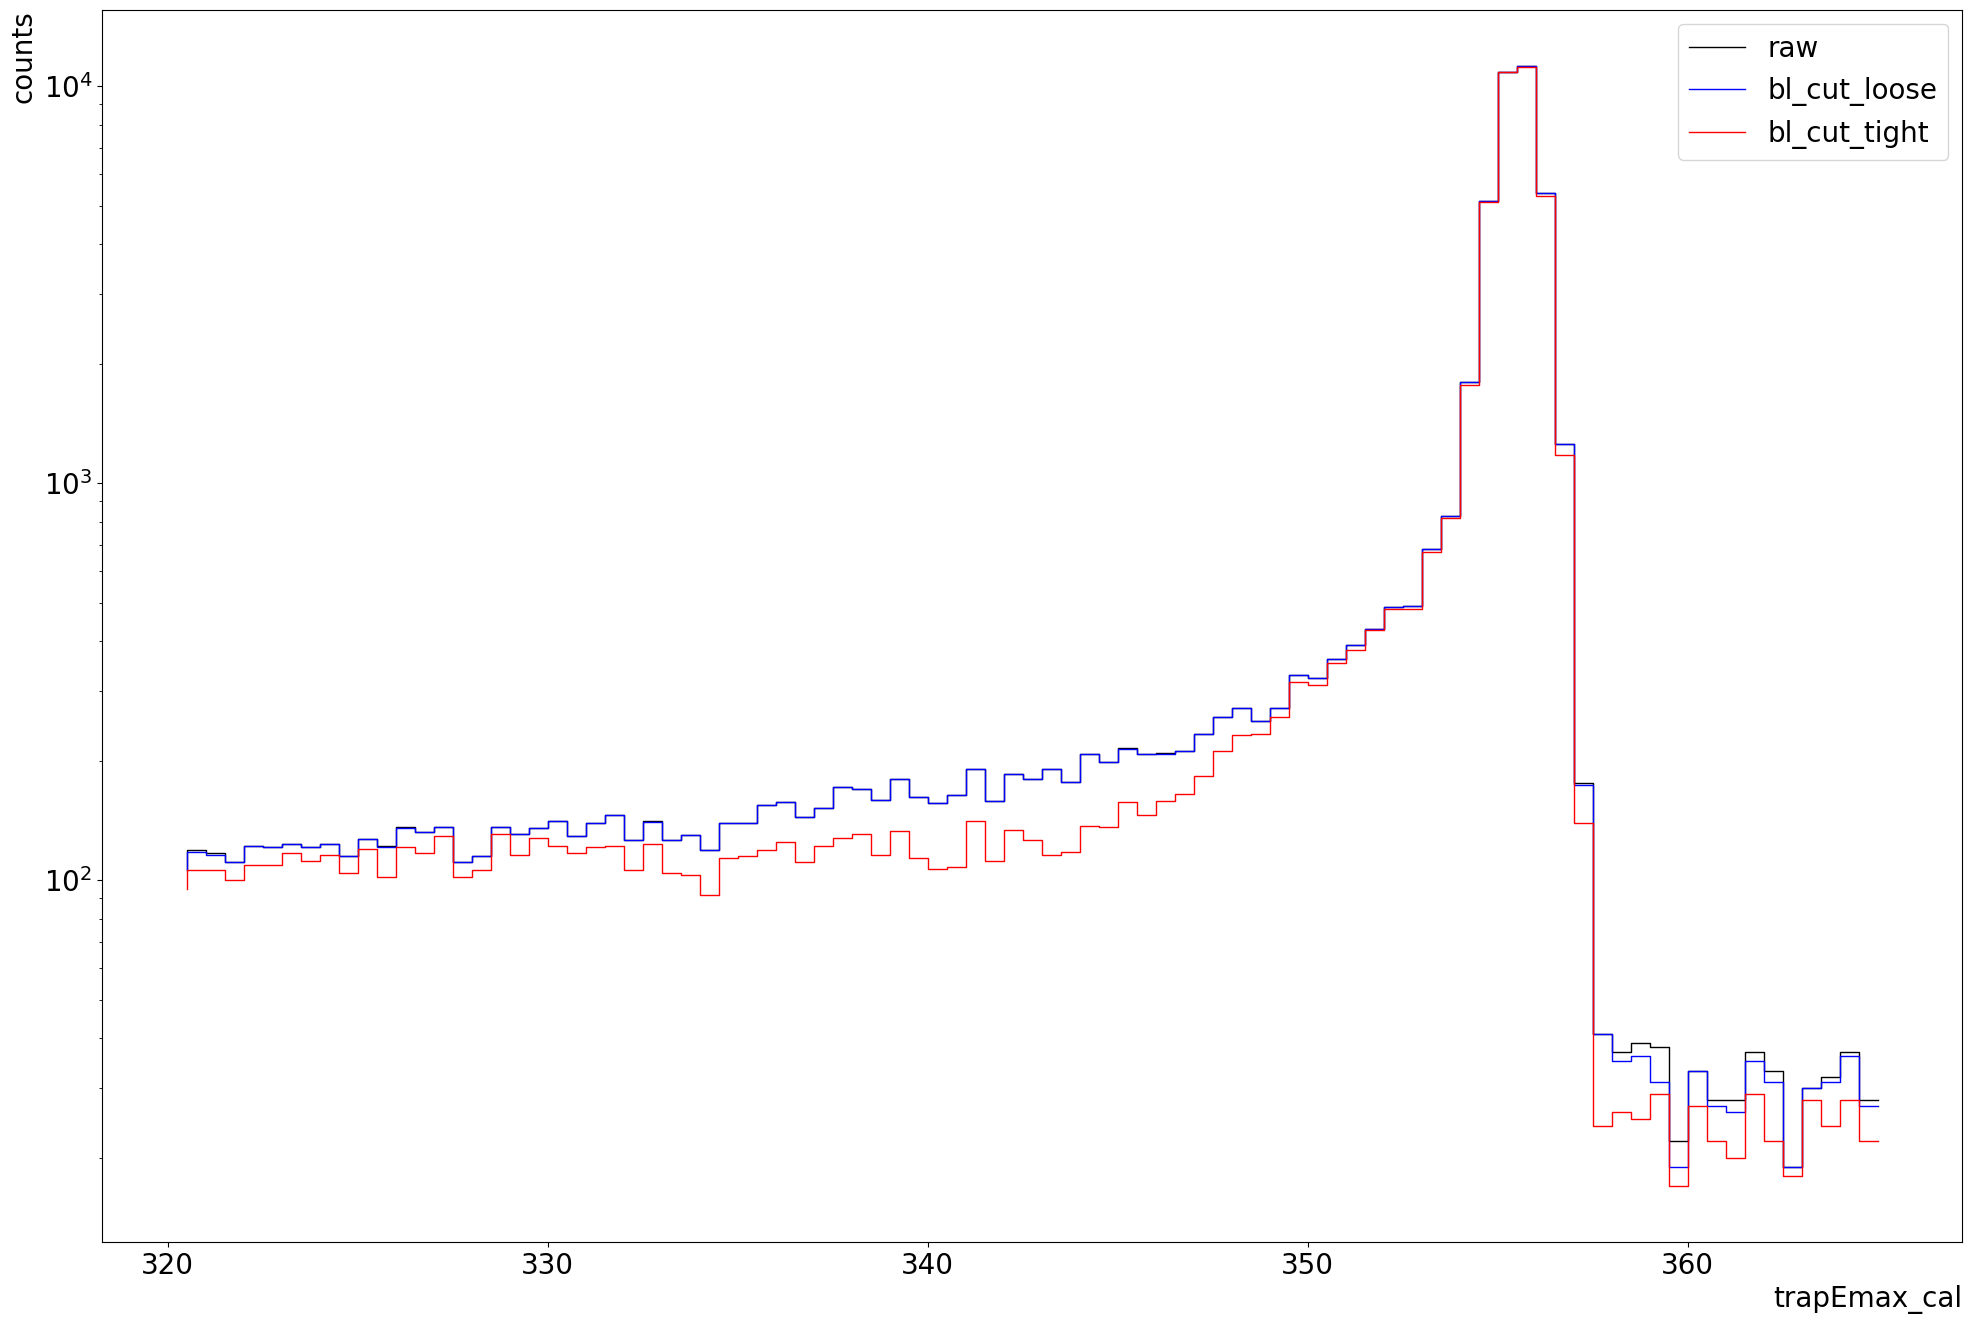

In [7]:

beginning_cycle = 2019

#cycle_range = [2028,2038, 'bkg'] #run 2
#cycle_range = [2039,2058, 'kry'] #run 3
cycle_range = [2112,2114, 'Ba133'] #run 7

cut_loose = [57550,58650]
cut_tight = [58000,58150]

lh5_dir = dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']


hit_list = dsp_list[cycle_range[0]-beginning_cycle:cycle_range[1]-beginning_cycle]
#hit_list = dsp_list[2039-2019]
df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl', 'bl_sig', 'A_10'], 'ORSIS3302DecoderForEnergy/dsp')
current_pars = [0.4494, 0.1825]
df_hit['trapEmax_cal'] = np.polyval(current_pars, df_hit['trapEmax'])





elo, ehi, epb = 0, 50, 1
blo, bhi, bpb = 55000, 60000, 100
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

fontsize = 20
plt.figure(figsize=(24,16))
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
h = plt.hist2d(df_hit['trapEmax'], df_hit['bl'], bins=[nbx,nby], 
               range=[[elo, ehi], [blo, bhi]], cmap='jet')

colorbar = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('trapEmax', ha='right', x=1, fontsize = fontsize)
plt.ylabel('bl', ha='right', y=1, fontsize = fontsize)


df_cut = df_hit.query('bl>58100 and bl<59000')
df_cut['aoe']= df_cut['A_10']/df_cut['trapEmax']
df_cut


alo, ahi, apb = 0, 0.4, 0.005
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 6000, 10
nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)
plt.figure(figsize=(15,10))


h = plt.hist2d(df_cut['trapEmax_cal'], df_cut['aoe'], bins=[nbx,nby],
               range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax_cal', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)



#baseline hist

hist_bl, bins_bl, var_bl = pgh.get_hist(df_hit['bl'], bins=2000)
plt.figure(figsize=(15,10))
pgh.plot_hist(hist_bl, bins_bl)
plotting(plt, xlabel='bl',ylabel='count', title='bl hist '+ cycle_range[2])


plt.axvline(cut_loose[0],color='b')
plt.axvline(cut_loose[1],color='b')
plt.axvline(cut_tight[0],color='r')
plt.axvline(cut_tight[1],color='r')
#plt.xlim(57800,58200)
plt.xlim(57000,59000)
plt.yscale('log')


etype = 'trapEmax_cal'
elo, ehi, epb = 320, 365, 0.5


plt.figure(figsize=(24,16))
# no cuts
h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), dx=epb)
x1 = x1[1:]
plt.plot(x1, h1, c='k', lw=1, ds='steps', label='raw')

# baseline cut
#loose
#df_cut = df_hit.query('bl>57550 and bl<58650')
df_cut = df_hit[(df_hit['bl']>cut_loose[0]) & (df_hit['bl']<cut_loose[1])]

h2, x2, v2 = pgh.get_hist(df_cut[etype], range=(elo, ehi), dx=epb)
#plt.plot(x1, h2, c='b', lw=1, ds='steps', 
#label='bl=['+str(cut_loose[0])+','+ str(cut_loose[1])+']')
plt.plot(x1, h2, c='b', lw=1, ds='steps', label='bl_cut_loose')

#tight
#df_cut = df_hit.query('bl>58050 and bl<58150')
df_cut = df_hit[(df_hit['bl']>cut_tight[0]) & (df_hit['bl']<cut_tight[1])]

h2, x2, v2 = pgh.get_hist(df_cut[etype], range=(elo, ehi), dx=epb)
#plt.plot(x1, h2, c='b', lw=1, ds='steps', 
#label='bl=['+str(cut_loose[0])+','+ str(cut_loose[1])+']')
plt.plot(x1, h2, c='r', lw=1, ds='steps', label='bl_cut_tight')

plt.xlabel(etype, ha='right', x=1, fontsize=fontsize)
plt.ylabel('counts', ha='right', y=1, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.yscale('log')

# dt cut 
dt = time difference between successive events
   = time difference between rise of waveforms of successive events

/tmp/ipykernel_61605/1318971703.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hit['dt'][i+1] = dt_clockticks/1e5 #converted to milliseconds
/tmp/ipykernel_61605/1318971703.py:28: RuntimeWarning: overflow encountered in ulong_scalars
  dt_clockticks = (df_hit['timestamp'][i+1]-df_hit['timestamp'][i]) #clockticks
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,trapEmax,bl,A_10,timestamp,trapEmax_cal,dt
0,59.189320,58087.003906,5.653572,1684985,25.641598,0.00000
1,684.405579,58085.238281,63.784595,1723494,295.109802,0.38509
2,101.410324,58087.343750,9.875875,3843449,43.838848,21.19955
3,558.232666,58088.144531,84.526749,4217343,240.729279,3.73894
4,738.613220,58088.945312,70.872055,4701952,318.473297,4.84609
...,...,...,...,...,...,...
1097618,647.744385,58083.199219,26.465031,156827403719,279.308838,3.19924
1097619,2086.705078,58063.972656,115.183449,156827510898,899.500854,1.07179
1097620,8444.427734,58086.394531,316.376740,156828106321,3639.679443,5.95423
1097621,38.798683,55088.507812,2.201310,156828194202,16.853233,0.87881


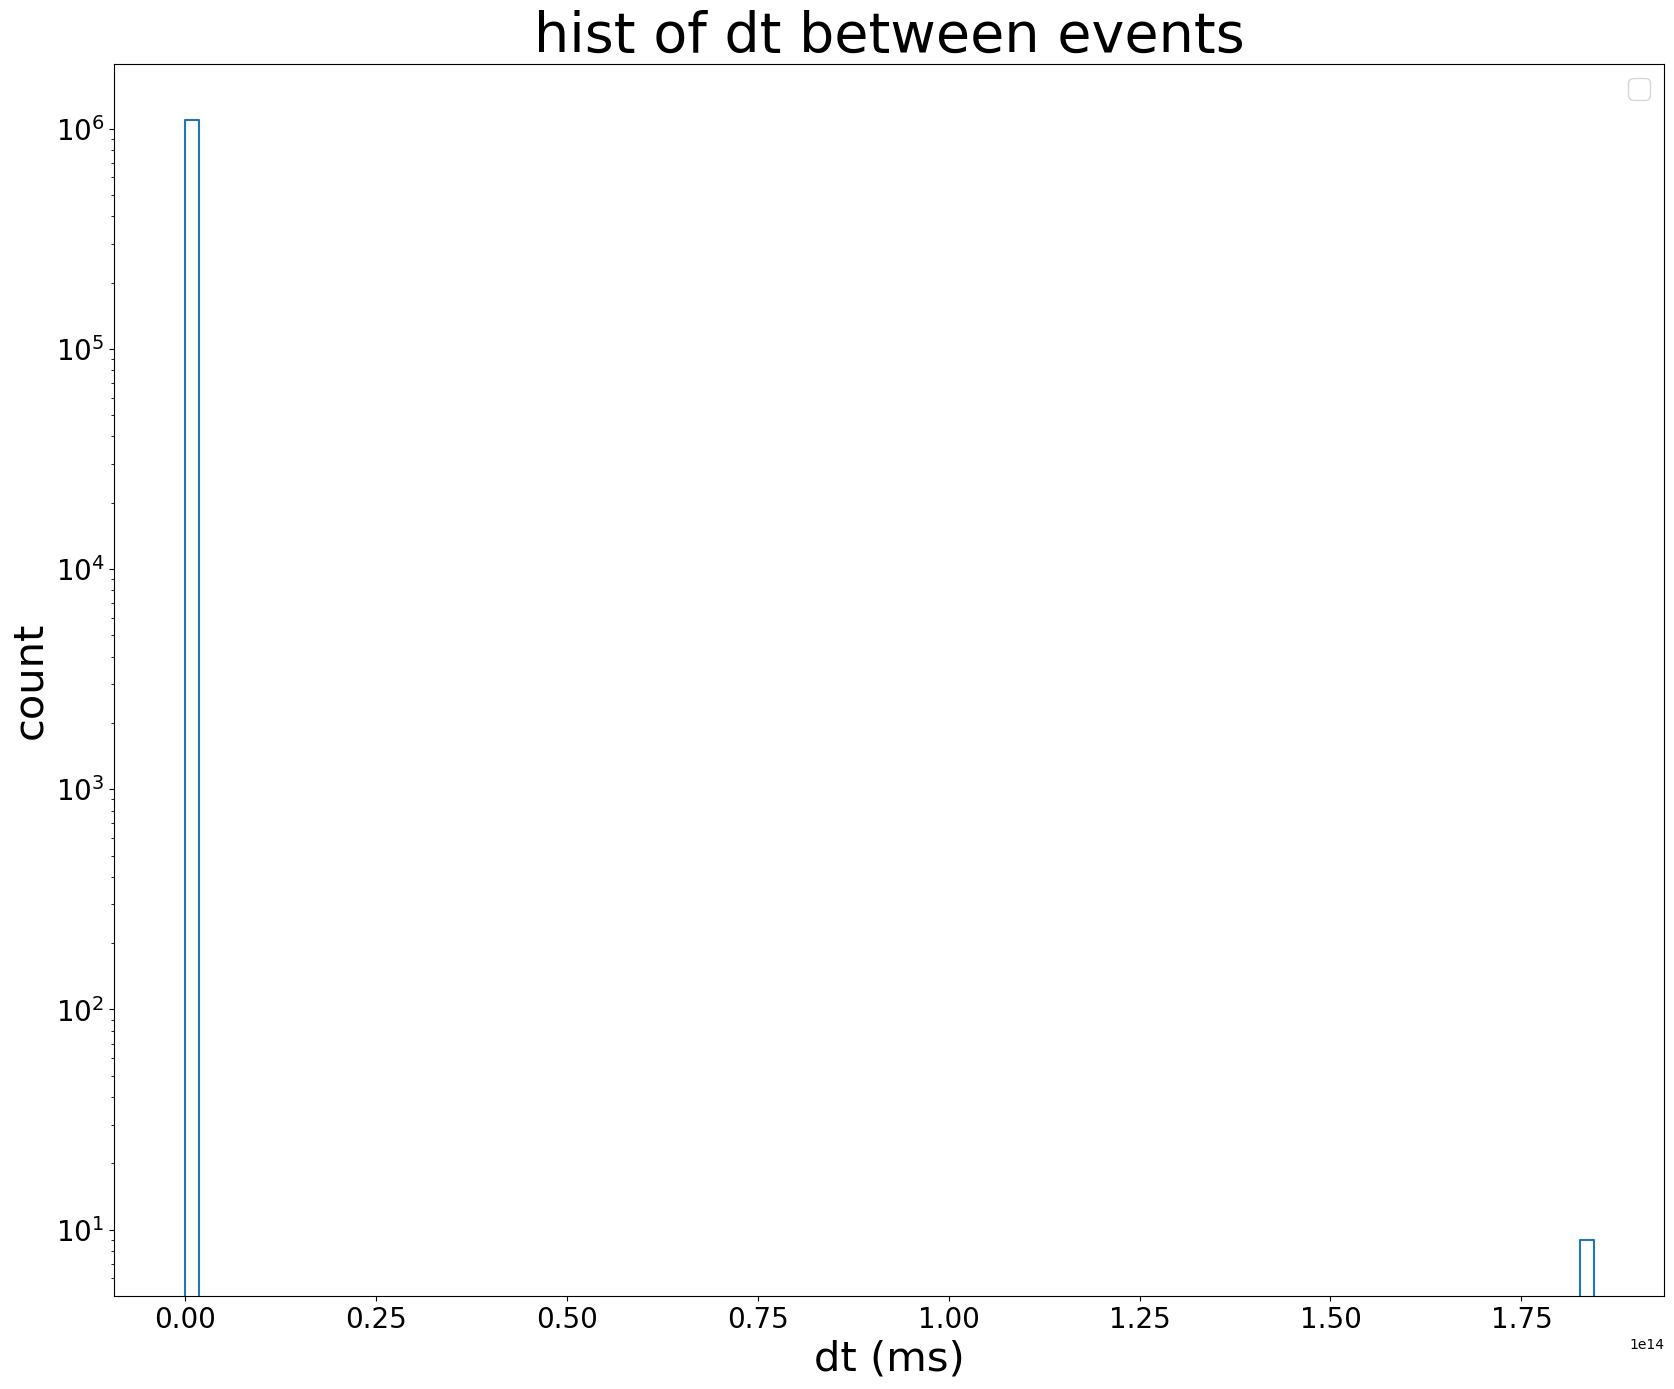

In [11]:

beginning_cycle = 2019
cycle_range = [2028,2038, 'bkg'] #run 2
#cycle_range = [2039,2058, 'kry'] #run 3
#cycle_range = [2020,2020, 'Ba133'] #run 7


lh5_dir = dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']


hit_list = dsp_list[cycle_range[0]-beginning_cycle:cycle_range[1]-beginning_cycle]
#hit_list = dsp_list[2039-2019]
'''
columns in file:
        ['trapE', 'bl', 'bl_sig', 'A_10', 'AoE', 'packet_id', 'ievt', 'energy',
        'energy_first', 'timestamp', 'crate', 'card', 'channel', 'energy_cal',
        'trapE_cal']'''


df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl', 'A_10', 'timestamp'], 'ORSIS3302DecoderForEnergy/dsp')
#timestamp is in unit of 10ns.
current_pars = [0.431, 0.131]
df_hit['trapEmax_cal'] = np.polyval(current_pars, df_hit['trapEmax'])

#adding dt to the dataframe in unit of nanoseconds
df_hit['dt']=0.0 #dt column will be in float
for i in range(len(df_hit)-1):
    dt_clockticks = (df_hit['timestamp'][i+1]-df_hit['timestamp'][i]) #clockticks
    df_hit['dt'][i+1] = dt_clockticks/1e5 #converted to milliseconds
    
dt_n_bins = 100
dt_hist, dt_bins, dt_var = pgh.get_hist(df_hit['dt'], bins=dt_n_bins)
draw_canvas(plt, xlabel='dt (ms)', ylabel='count', title='hist of dt between events')
pgh.plot_hist(dt_hist,dt_bins)
plt.yscale('log')


df_hit

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


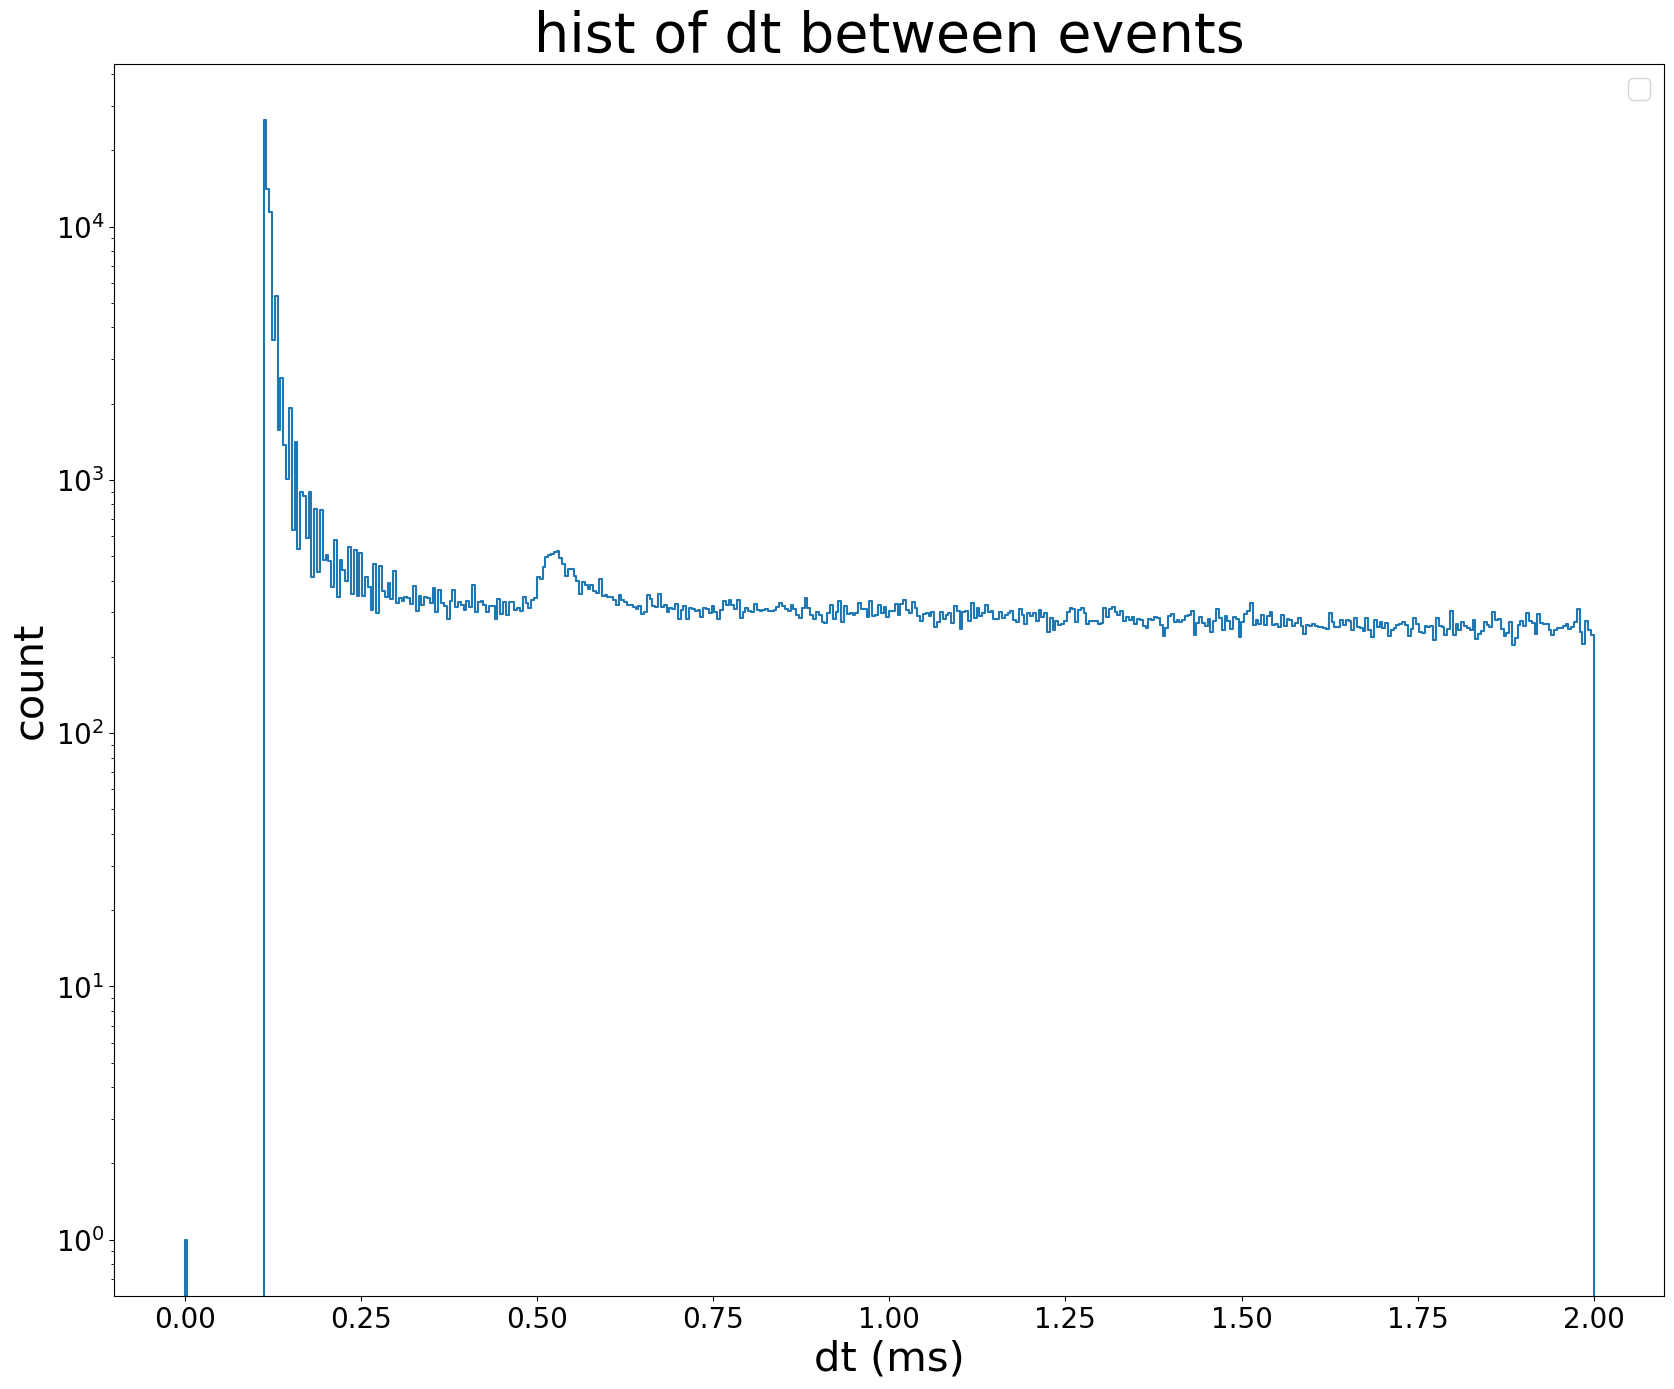

In [33]:
dt_hist, dt_bins, dt_var = pgh.get_hist(df_hit['dt'][df_hit.dt<2], bins=500)
draw_canvas(plt, xlabel='dt (ms)', ylabel='count', title='hist of dt between events')
pgh.plot_hist(dt_hist,dt_bins)
plt.yscale('log')

In [12]:
dt_range = [1,7] #milliseconds
bin_range = np.digitize(dt_range, dt_bins)
dt_bins_new = dt_bins[bin_range[0]:bin_range[1]+1]
dt_hist_new = dt_hist[bin_range[0]:bin_range[1]]
area = sum(np.diff(dt_bins_new)*dt_hist_new)
print('total area = ',sum(np.diff(dt_bins)*dt_hist))
print('area =',area)
params = np.polyfit(dt_bins_new[:-1],np.log(dt_hist_new), deg=1)
print(params)
draw_canvas(plt, xlabel='dt (ms)', ylabel='count', title='hist of dt between events')
pgh.plot_hist(dt_hist,dt_bins)
plt.yscale('log')
x = np.linspace(0,14)
y = np.exp(x*params[0]+params[1])
plt.plot(x,y)
plt.axvline(dt_range[0], color='r')
plt.axvline(dt_range[1], color='r')

total area =  2.0247570570396815e+18
area = 0


TypeError: expected non-empty vector for x

In [ ]:
max(livetimes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


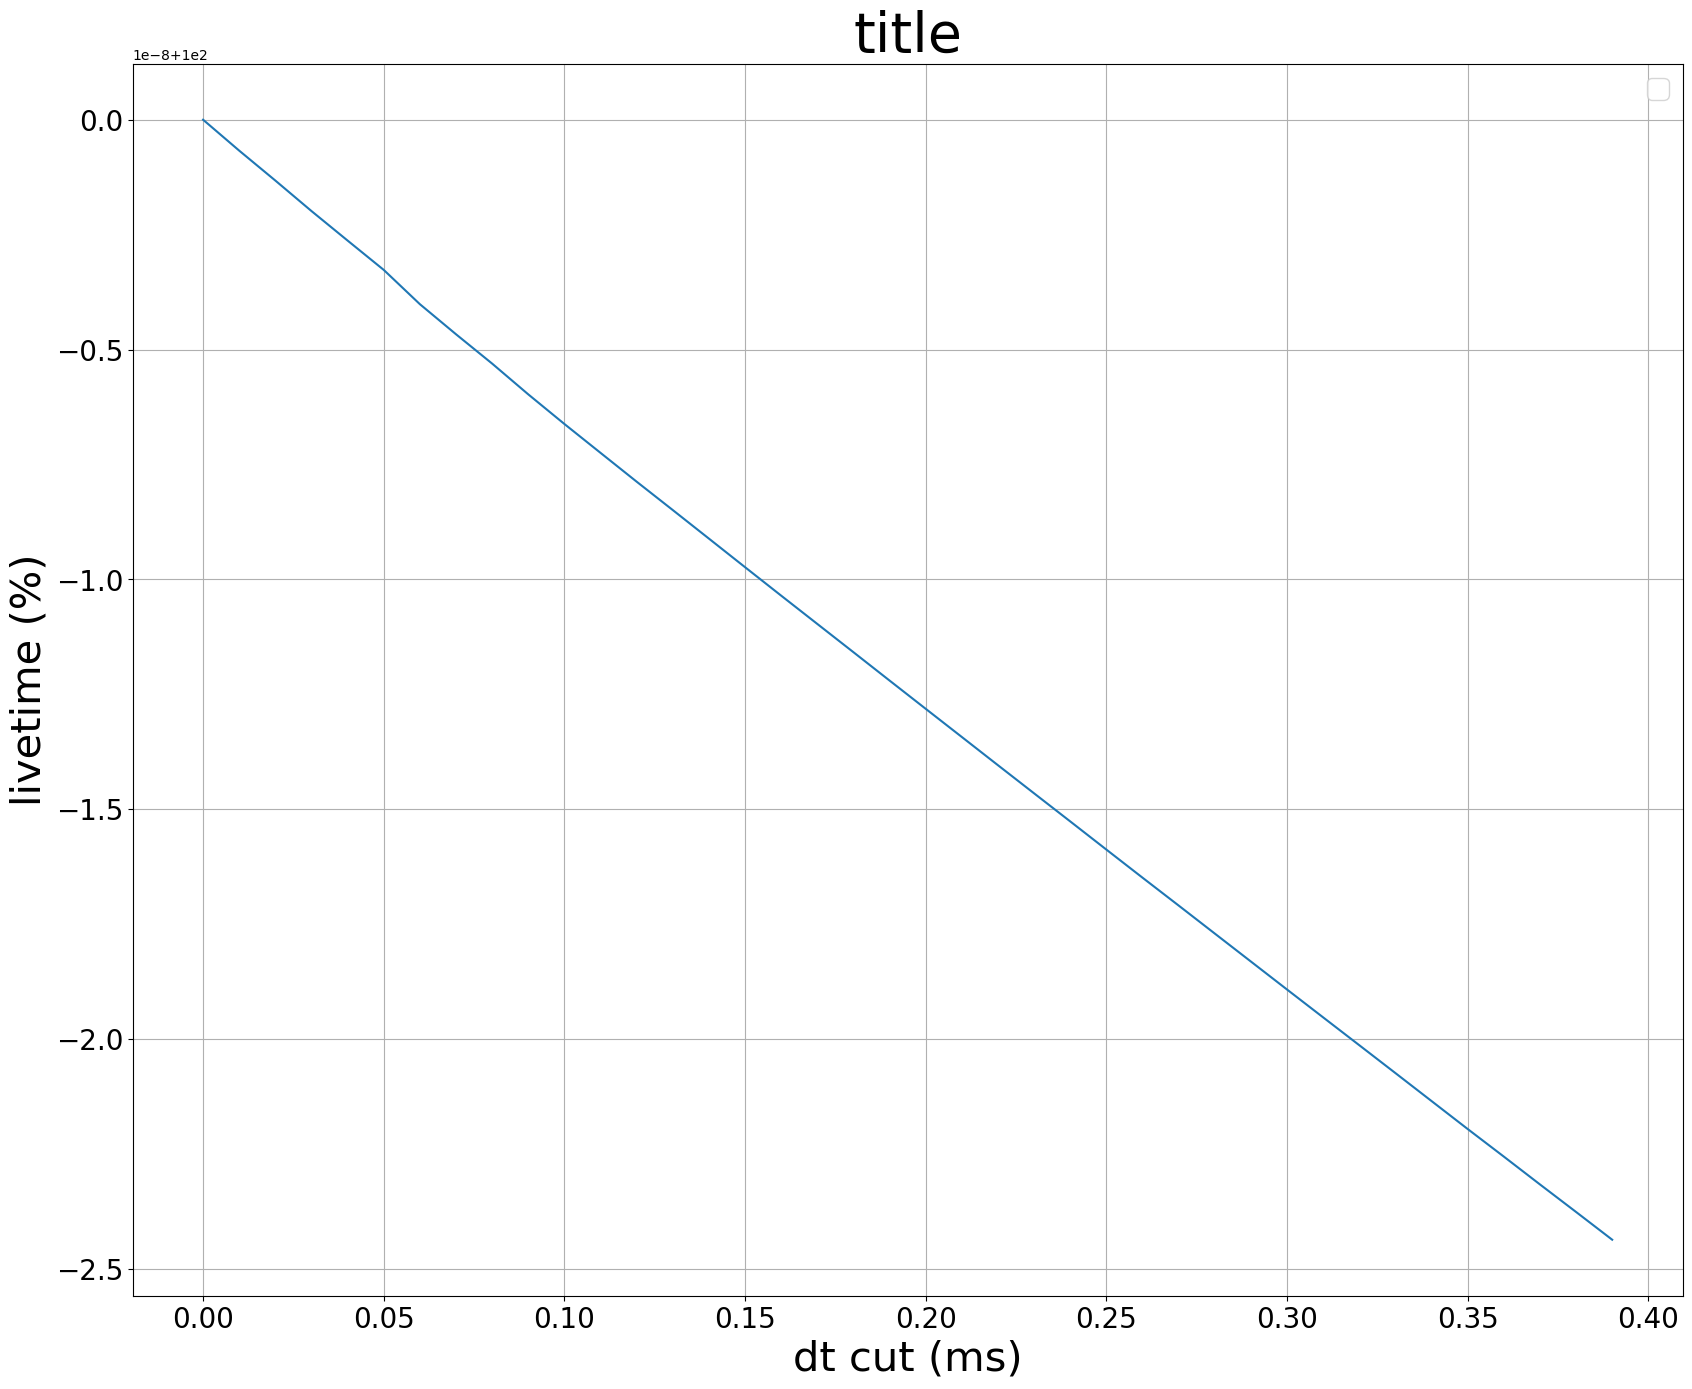

In [13]:
cut_passed=0
dt_cut_vals = []
livetimes = []
for dt_cut in np.arange(0,0.4,0.01):
    livetime = 0
    dt_cut_vals.append(dt_cut)
    for i in range(len(df_hit)):
        dt = df_hit['dt'][i]
        if(dt>dt_cut):
            cut_passed = cut_passed + 1
            livetime = livetime + (dt-dt_cut) #so livetime in milliseconds
    #livetime = livetime/(1000*60) #converted to mins
    livetimes.append(livetime)
    #print('cut passed: ',cut_passed)
    #print('livetime: ',livetime)

max_livetime = max(livetimes)
percent_livetimes = livetimes/max_livetime*100
draw_canvas(plt, xlabel='dt cut (ms)', ylabel='livetime (%)')
plt.plot(dt_cut_vals, percent_livetimes)
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


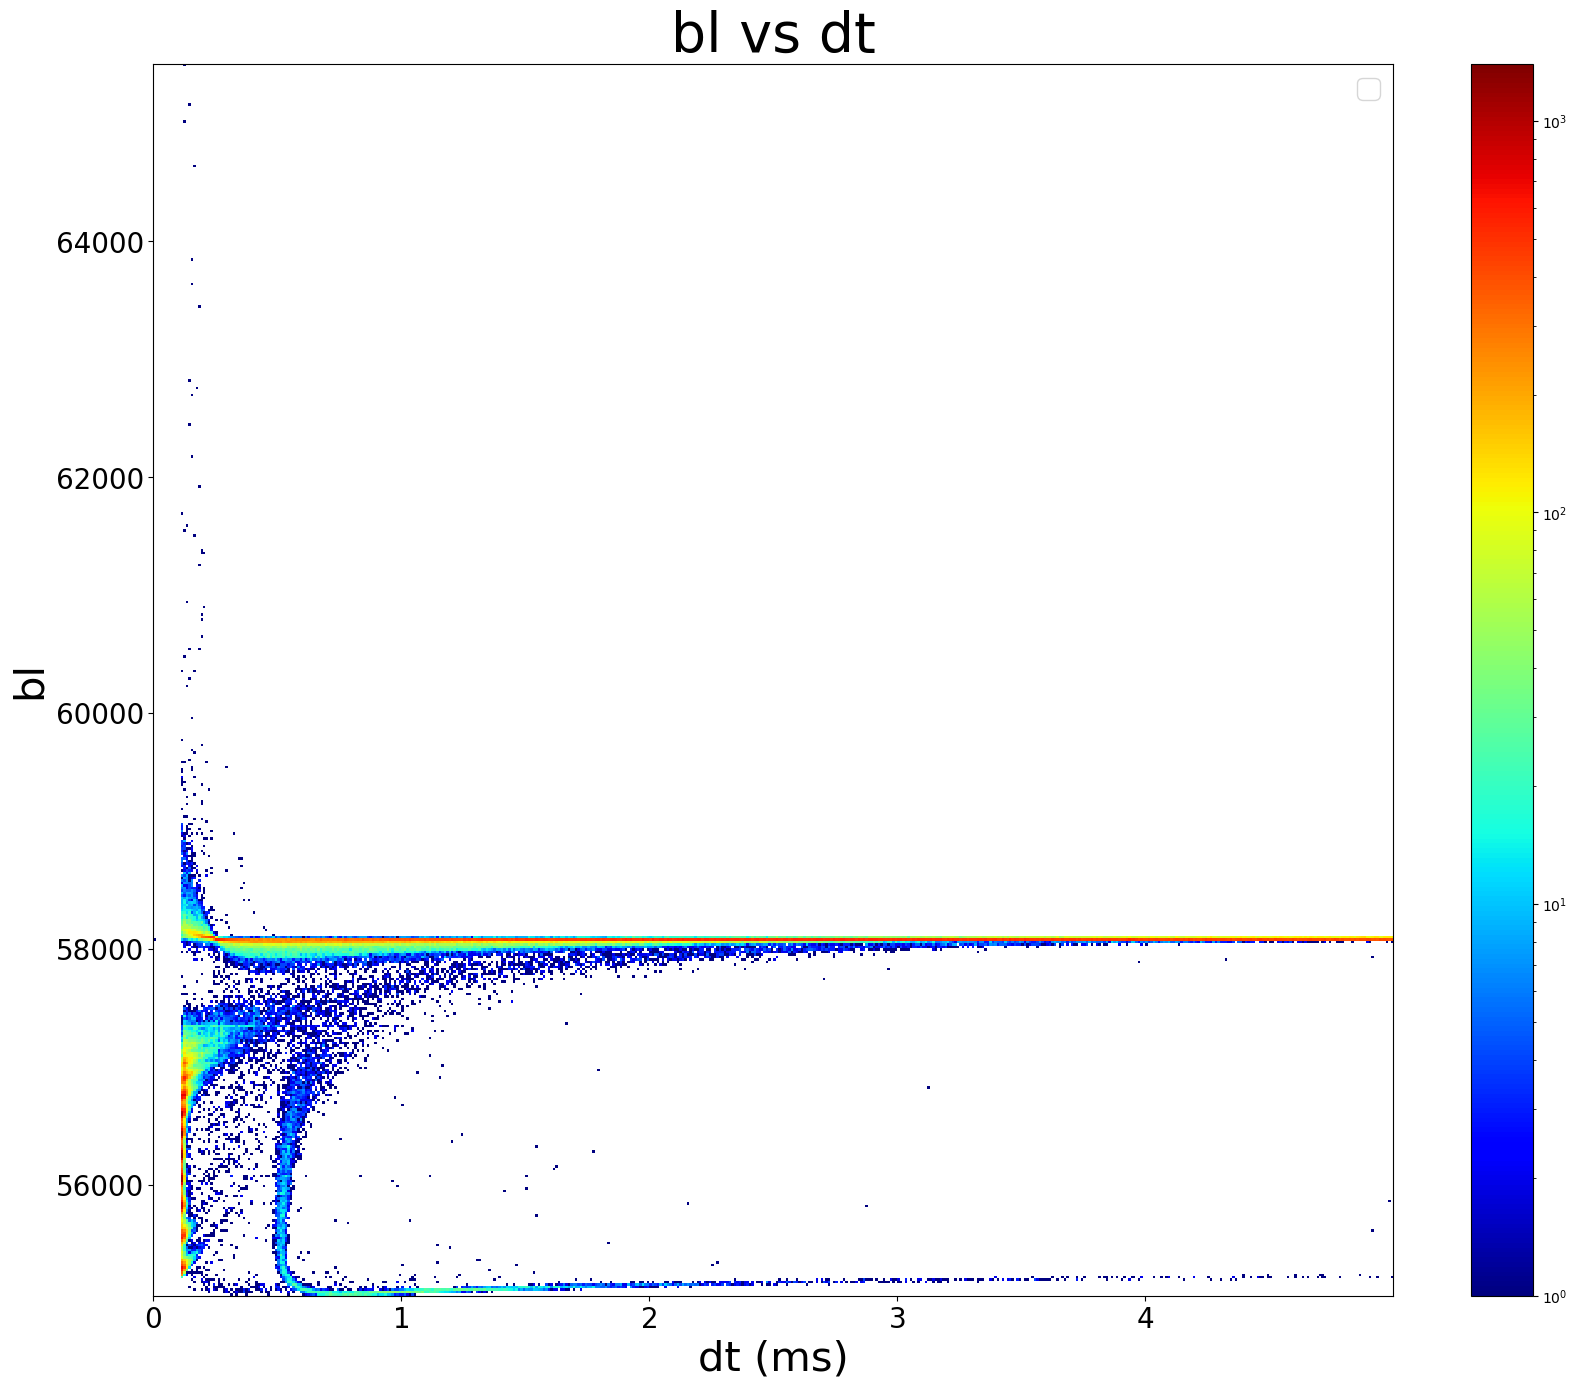

In [45]:
ylabel = 'bl'
#ylabel = 'trapEmax'
draw_canvas(plt, xlabel='dt (ms)', ylabel=ylabel, title='bl vs dt')
h = plt.hist2d(df_hit['dt'][df_hit.dt<5], df_hit[ylabel][df_hit.dt<5], cmap='jet', 
               norm=matplotlib.colors.LogNorm(), bins=[500,500])

colorbar = plt.colorbar(h[3], ax=plt.gca())
#plt.title('bl vs dt')

### Why is the time difference between events important?
A: events happening too close to previous one will not have well defined baseline and also affect the topline (=trapEmax) of the previous one, that's why. Also infact these too close happening events make the topline slope down instead of staying constant.

### Energy spectrum for dt cuts

In [ ]:
max(df_hit['dt']) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


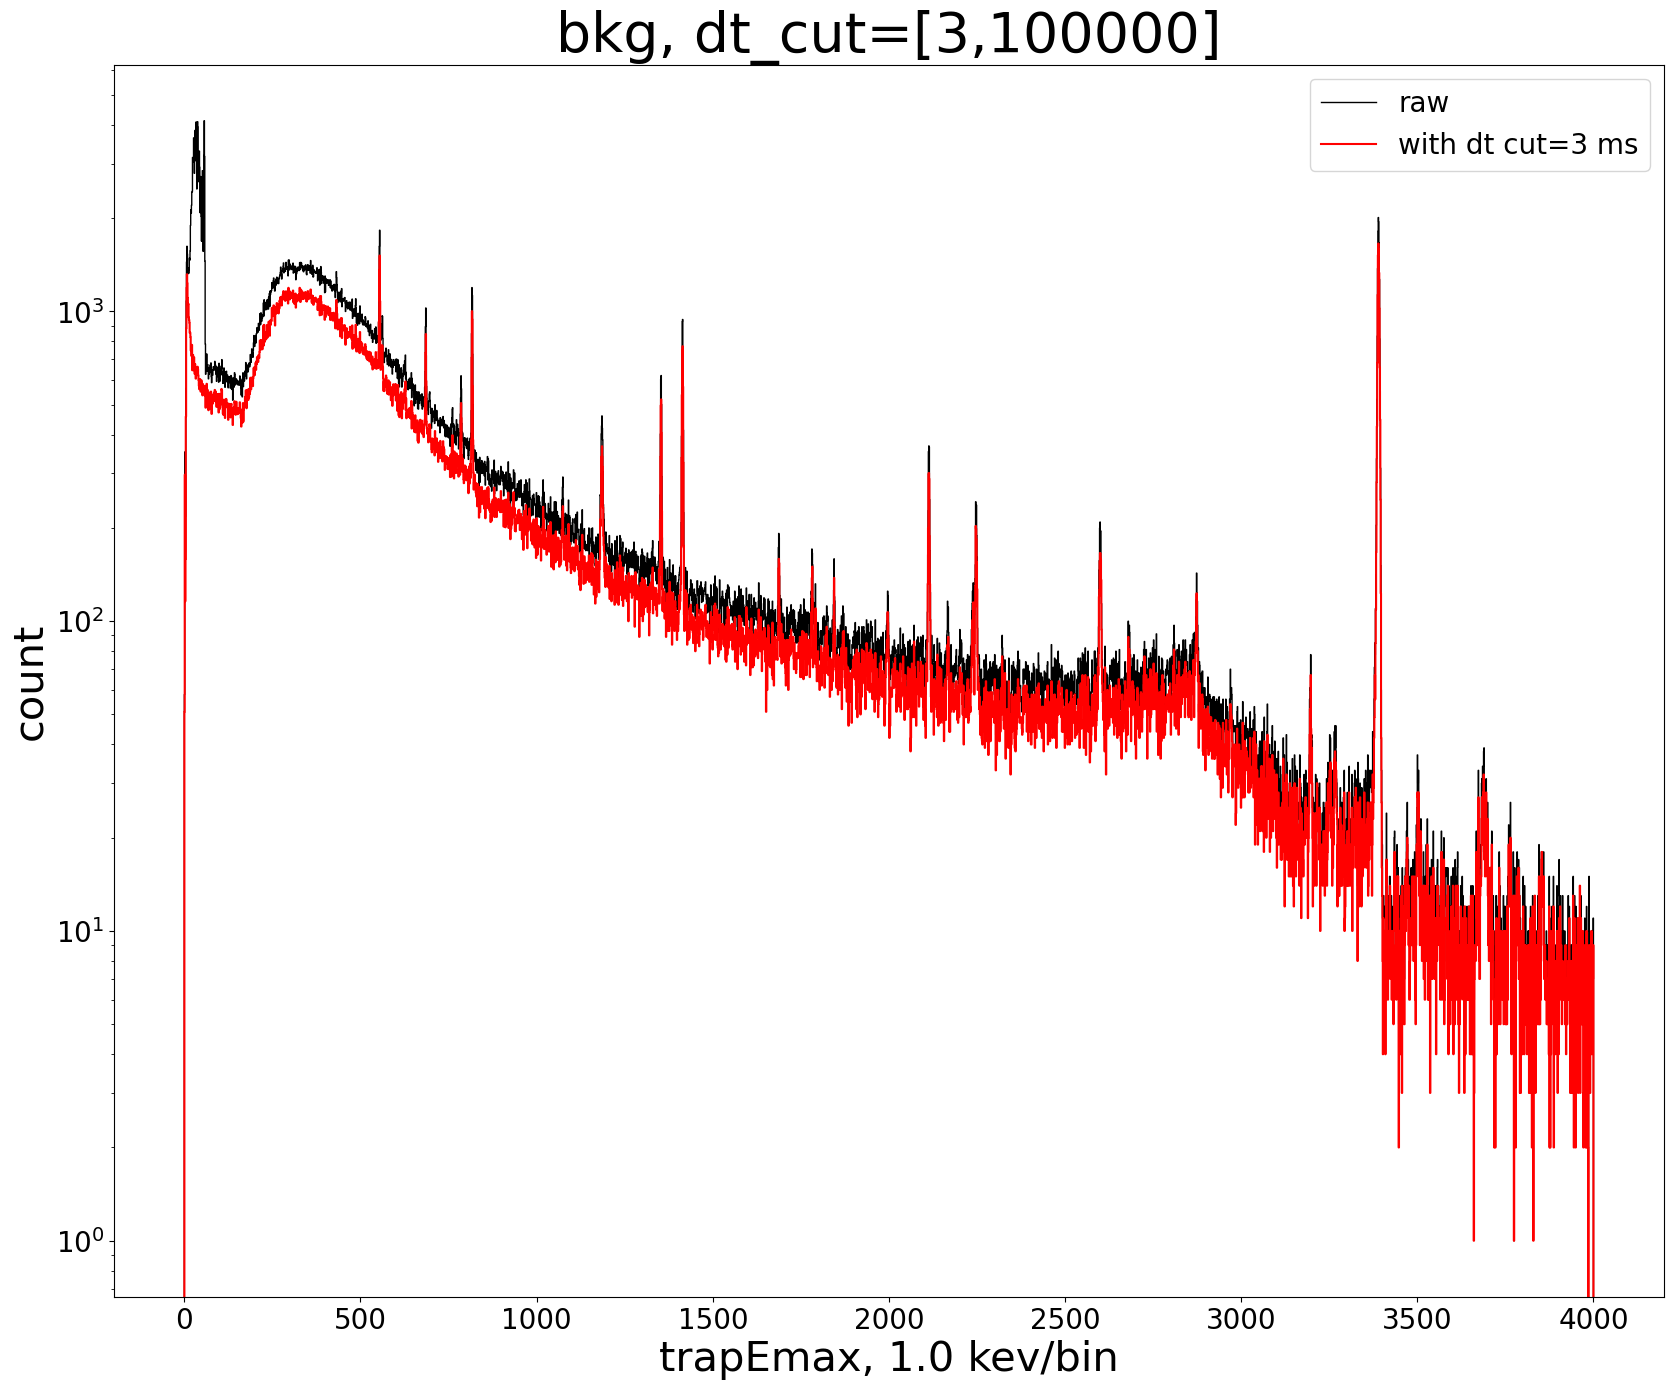

In [44]:
dt_cut_point = 3 #millisecond
dt_cut_range = [dt_cut_point, 100000]
dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
etype='trapEmax'

elo = 0
ehi = 4000

n_bins = 4000

kev_per_bin = (ehi-elo)/n_bins

draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
      str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')



h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
#x1 = x1[2:]
pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
plt.yscale('log')


h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax'], range=(elo, ehi), bins=n_bins)
#x2=x2[2:]
pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
plt.yscale('log')
#plt.xlim(335,365)

plt.legend(fontsize=fontsize)

### fitting a gaussian function to Ba peak

In [18]:
dt_cut_point = 0.5 #millisecond
dt_cut_range = [dt_cut_point, max(df_hit['dt'])]
dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
etype='trapEmax_cal'
#draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
      #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

elo = 0
ehi = 4000

n_bins = 4000*5

kev_per_bin = (ehi-elo)/n_bins

#h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
#x1 = x1[1:]
#pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
#plt.yscale('log')


h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), 
                          bins=n_bins)

Ba_ene_range = [355,358]
Ba_bin_range = np.digitize(Ba_ene_range, x2)
print(Ba_bin_range)

Ba_hist = h2[Ba_bin_range[0]:Ba_bin_range[1]]
Ba_bins = x2[Ba_bin_range[0]:Ba_bin_range[1]]
Ba_var = v2[Ba_bin_range[0]:Ba_bin_range[1]]

n_sigma = 5
imax, imin = cb.get_i_local_extrema(Ba_hist/np.sqrt(Ba_var), n_sigma)
print('Max at: ',Ba_bins[imax])
print(len(Ba_bins))
Ba_bin_centers = pgh.get_bin_centers(Ba_bins)
pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(Ba_hist, Ba_bins, Ba_var, [356.5],
                                           n_to_fit=n_sigma, poissonLL=[False])
Ba_sigma = pt_pars[0][1]
print('pt_pars: ', pt_pars)


draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
      str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
#x1 = x1[2:]
pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
plt.yscale('log')


pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
plt.yscale('log')
plt.xlim(335,365)
pgu.plot_func(pgf.gauss_basic, pt_pars[0], range=(Ba_ene_range[0],Ba_ene_range[1]),
             label='Gaussian fit')
#calculating chi square
#x = np.arange(355,358,0.1)
Ba_bin_centers = pgh.get_bin_centers(Ba_bins)
chisquare = stats.chisquare(Ba_bin_centers, 
                            f_exp=pgf.gauss_basic(Ba_bin_centers, *pt_pars[0]))[0]
print('$\chi^2$=',chisquare)
plt.legend(fontsize=20)

[1776 1791]


NameError: name 'cb' is not defined

In [19]:
cuts = []
chisquares_per_dof = []
for cut_point in np.arange(0,4,0.1):
    cuts.append(cut_point)
    dt_cut_range = [cut_point,max(df_hit['dt'])]
    dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
    etype='trapEmax_cal'
    #draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    elo = 0
    ehi = 4000

    n_bins = 4000*5

    #h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
    #x1 = x1[1:]
    #pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
    #plt.yscale('log')


    h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), 
                          bins=n_bins)

    Ba_ene_range = [355,358]
    Ba_bin_range = np.digitize(Ba_ene_range, x2)
    #print(Ba_bin_range)

    Ba_hist = h2[Ba_bin_range[0]:Ba_bin_range[1]]
    Ba_bins = x2[Ba_bin_range[0]:Ba_bin_range[1]]
    Ba_var = v2[Ba_bin_range[0]:Ba_bin_range[1]]

    n_sigma = 3
    imax, imin = cb.get_i_local_extrema(Ba_hist/np.sqrt(Ba_var), n_sigma)
    #print(imax, imin)
    Ba_bin_centers = pgh.get_bin_centers(Ba_bins)
    pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(Ba_hist, Ba_bins, Ba_var, [356.5],
                                               n_to_fit=n_sigma, poissonLL=[False])
    Ba_sigma = pt_pars[0][1]
    Ba_bin_centers = pgh.get_bin_centers(Ba_bins)
    '''
    chisquare = stats.chisquare(Ba_bin_centers, 
                                f_exp=pgf.gauss_basic(Ba_bin_centers, *pt_pars[0]))[0]
    '''
    
    
    chisquare = 0.0
    for j in range(len(Ba_bin_centers)):
        a = Ba_hist[j]
        b = pgf.gauss_basic(Ba_bin_centers[j], *pt_pars[0])
        #error = np.sqrt(Ba_var[j])
        chisquare = chisquare + ((a-b)**2)/Ba_var[j]
    
    dof = len(Ba_bin_centers)-1-2
    chisquares_per_dof.append(chisquare/dof)

#print("\n".join("{} {}".format(x, y) for x, y in zip(cuts, chisquares)))
draw_canvas(plt, xlabel='dt cuts (ms)', ylabel='chi2/dof')
plt.plot(cuts, chisquares_per_dof)


NameError: name 'cb' is not defined

### fitting gauss(mu,sigma,A) + [bkg] + step[x1,x2]

In [ ]:
def goodness_of_fit(hist, bins, var, func, pars, method='var'):
    """ Compute chisq and dof of fit

    Parameters
    ----------
    hist, bins, var : array, array, array or None
        histogram data. var can be None if hist is integer counts
    func : function
        the function that was fit to the hist
    pars : array
        the best-fit pars of func. Assumes all pars are free parameters
    method : str
        Sets the choice of "denominator" in the chi2 sum
        'var': user passes in the variances in var (must not have zeros)
        'Pearson': use func (hist must contain integer counts)
        'Neyman': use hist (hist must contain integer counts and no zeros)

    Returns
    -------
    chisq : float
        the summed up value of chisquared
    dof : int
        the number of degrees of freedom
    """
    # arg checks
    if method == 'var':
        if var is None:
            print("goodness_of_fit: var must be non-None to use method 'var'")
            return 0, 0
        if np.any(var==0):
            print("goodness_of_fit: var cannot contain zeros")
            return 0, 0
    if method == 'Neyman' and np.any(hist==0):
        print("goodness_of_fit: hist cannot contain zeros for Neyman method")
        return 0, 0

    # compute chi2 numerator and denominator
    
    yy = func(pgh.get_bin_centers(bins), *pars)
    numerator = (hist - yy)**2
    if method == 'var':
        denominator = var
    elif method == 'Pearson':
        denominator = yy
    elif method == 'Neyman':
        denominator = hist
    else:
        print(f"goodness_of_fit: unknown method {method}")
        return 0, 0

    # compute chi2 and dof 
    chisq = np.sum(numerator/denominator)
    dof = len(hist) - len(pars)
    return chisq, dof

In [ ]:
def fitting_func(x,mu, sigma, height=1, bkg=0, step_factor=-15):
    gaussian = height * np.exp(-(x - mu)**2 / (2. * sigma**2)) + bkg + step_factor*np.heaviside((x-mu), 1)
    return gaussian

dt_cut_point = 0.4 #millisecond
dt_cut_range = [dt_cut_point, max(df_hit['dt'])]
dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
etype='trapEmax_cal'
#draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
      #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

elo = 0
ehi = 4000

n_bins = 4000*5

kev_per_bin = (ehi-elo)/n_bins


h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), 
                          bins=n_bins)

fitting_ene_range = [335,365]
fitting_bin_range = np.digitize(fitting_ene_range, x2)
print(fitting_bin_range)

fitting_hist = h2[fitting_bin_range[0]:fitting_bin_range[1]]
fitting_bins = x2[fitting_bin_range[0]:fitting_bin_range[1]+1]
fitting_var = v2[fitting_bin_range[0]:fitting_bin_range[1]]

n_sigma = 5
imax, imin = cb.get_i_local_extrema(fitting_hist/np.sqrt(fitting_var), n_sigma)
print('Max at: ',fitting_bins[imax])
print(len(fitting_bins))
fitting_bin_centers = pgh.get_bin_centers(fitting_bins)


'''
pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(fitting_hist, fitting_bins, fitting_var, [356.5],
                                           n_to_fit=n_sigma, poissonLL=[False])

fitting_sigma = pt_pars[0][1]
print('pt_pars: ', pt_pars)
'''
#pars, covs = curve_fit(fitting_func, fitting_bins, fitting_hist)
guessed_params = (356.0, 1.0, 11000, 5, -15)
pars, covs = pgf.fit_hist(fitting_func, fitting_hist, fitting_bins, fitting_var, 
                          guess=guessed_params)
print('pars:',pars)

draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
      str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
#x1 = x1[2:]
pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
plt.yscale('log')


pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
plt.yscale('log')
plt.xlim(335,365)
#pgu.plot_func(fitting_func, pars, range=(fitting_ene_range[0],fitting_ene_range[1]), label='Gauss+bkg+step')
pgu.plot_func(fitting_func, pars, range=(335,365),
             label='Gauss+bkg+step')
#calculating chi square
#x = np.arange(355,358,0.1)
fitting_bin_centers = pgh.get_bin_centers(fitting_bins)
'''
chisquare = stats.chisquare(fitting_hist, 
                            f_exp=fitting_func(fitting_bin_centers, *pars))[0]
print(chisquare)
chisquare = 0.0
chisquare2 = 0.0
for i, j in enumerate(range(len(fitting_bin_centers))):
    a = fitting_hist[j]
    b = fitting_func(fitting_bin_centers[j], *pars)
    #error = np.sqrt(Ba_var[j])
    chisquare = chisquare + ((a-b)**2)/fitting_var[j]
    chisquare2 = chisquare2 + ((a-b)**2)/b
    if i < 10:
        print(i, j, chisquare, chisquare2)

dof = len(fitting_bin_centers)-1-2
chisquare_per_dof = chisquare/dof
'''
chisqaure, dof = goodness_of_fit(fitting_hist, fitting_bins, fitting_var, 
                              fitting_func, pars, method='Pearson')
chisquare_per_dof = chisqaure/dof
print('chi2/dof=',chisquare_per_dof)
plt.legend(fontsize=20)
    

In [ ]:
dt_cuts = []
chisquare_per_dofs = []
for i in np.arange(0,1,0.05):
    dt_cut_point = i #millisecond
    dt_cuts.append(dt_cut_point)
    dt_cut_range = [dt_cut_point, max(df_hit['dt'])]
    dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
    etype='trapEmax_cal'
    #draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    elo = 0
    ehi = 4000

    n_bins = 4000*5

    kev_per_bin = (ehi-elo)/n_bins


    h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), 
                              bins=n_bins)

    fitting_ene_range = [335,365]
    fitting_bin_range = np.digitize(fitting_ene_range, x2)
    #print(fitting_bin_range)

    fitting_hist = h2[fitting_bin_range[0]:fitting_bin_range[1]]
    fitting_bins = x2[fitting_bin_range[0]:fitting_bin_range[1]+1]
    fitting_var = v2[fitting_bin_range[0]:fitting_bin_range[1]]

    n_sigma = 5
    imax, imin = cb.get_i_local_extrema(fitting_hist/np.sqrt(fitting_var), n_sigma)
    #print('Max at: ',fitting_bins[imax])
    #print(len(fitting_bins))
    fitting_bin_centers = pgh.get_bin_centers(fitting_bins)


    '''
    pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(fitting_hist, fitting_bins, fitting_var, [356.5],
                                               n_to_fit=n_sigma, poissonLL=[False])

    fitting_sigma = pt_pars[0][1]
    print('pt_pars: ', pt_pars)
    '''
    #pars, covs = curve_fit(fitting_func, fitting_bins, fitting_hist)
    guessed_params = (356.0, 1.0, 11000, 5, -15)
    pars, covs = pgf.fit_hist(fitting_func, fitting_hist, fitting_bins, fitting_var, 
                              guess=guessed_params)
    #print('pars:',pars)

    #draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
    #x1 = x1[2:]
    #pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
    #plt.yscale('log')


    #pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
    #plt.yscale('log')
    #plt.xlim(335,365)
    #pgu.plot_func(fitting_func, pars, range=(fitting_ene_range[0],fitting_ene_range[1]), label='Gauss+bkg+step')
    #pgu.plot_func(fitting_func, pars, range=(335,365),
                 #label='Gauss+bkg+step')
    #calculating chi square
    #x = np.arange(355,358,0.1)
    fitting_bin_centers = pgh.get_bin_centers(fitting_bins)
    '''
    chisquare = stats.chisquare(fitting_hist, 
                                f_exp=fitting_func(fitting_bin_centers, *pars))[0]
    print(chisquare)
    chisquare = 0.0
    chisquare2 = 0.0
    for i, j in enumerate(range(len(fitting_bin_centers))):
        a = fitting_hist[j]
        b = fitting_func(fitting_bin_centers[j], *pars)
        #error = np.sqrt(Ba_var[j])
        chisquare = chisquare + ((a-b)**2)/fitting_var[j]
        chisquare2 = chisquare2 + ((a-b)**2)/b
        if i < 10:
            print(i, j, chisquare, chisquare2)

    dof = len(fitting_bin_centers)-1-2
    chisquare_per_dof = chisquare/dof
    '''
    chisqaure, dof = goodness_of_fit(fitting_hist, fitting_bins, fitting_var, 
                                  fitting_func, pars, method='Pearson')
    chisquare_per_dof = chisqaure/dof
    chisquare_per_dofs.append(chisquare_per_dof)
    #print('chi2/dof=',chisquare_per_dof)
    #plt.legend(fontsize=20)
print("\n".join("{} {}".format(x, y) for x, y in zip(dt_cuts, chisquare_per_dofs)))
draw_canvas(plt, xlabel='dt cuts (ms)', ylabel='chi2/dof')
plt.plot(dt_cuts, chisquare_per_dofs)

In [ ]:
cuts = []
sigmas = []
for cut_point in np.arange(0,5,0.1):
    cuts.append(cut_point)
    dt_cut_range = [cut_point,max(df_hit['dt'])]
    dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
    etype='trapEmax_cal'
    #draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    elo = 0
    ehi = 4000

    n_bins = 4000*5

    #h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
    #x1 = x1[1:]
    #pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
    #plt.yscale('log')


    h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), 
                          bins=n_bins)

    Ba_ene_range = [355,358]
    Ba_bin_range = np.digitize(Ba_ene_range, x2)
    #print(Ba_bin_range)

    Ba_hist = h2[Ba_bin_range[0]:Ba_bin_range[1]]
    Ba_bins = x2[Ba_bin_range[0]:Ba_bin_range[1]]
    Ba_var = v2[Ba_bin_range[0]:Ba_bin_range[1]]

    n_sigma = 3
    imax, imin = cb.get_i_local_extrema(Ba_hist/np.sqrt(Ba_var), n_sigma)
    #print(imax, imin)
    Ba_bin_centers = pgh.get_bin_centers(Ba_bins)
    pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(Ba_hist, Ba_bins, Ba_var, [356.5],
                                               n_to_fit=n_sigma, poissonLL=[False])
    Ba_sigma = pt_pars[0][1]
    sigmas.append(Ba_sigma)
    #print(j)

print("\n".join("{} {}".format(x, y) for x, y in zip(cuts, sigmas)))
draw_canvas(plt, xlabel='dt cuts (ms)', ylabel='resolution (sigma of gaussian fitting of the Ba peak)')
plt.plot(cuts, sigmas)